# Image Classification using Bag of Visual Words development - Week 1

Team 4:
- Álvaro Díaz
- Benet Ramió
- Oussama Ammouri
- Marina Rosell

## Introduction

This project implements a complete Bag of Visual Words (BoVW) pipeline to classify images into 11 semantic scene categories (e.g., Forest, Downtown, Kitchen) using a subset of the Places365 dataset.

The pipeline consists of the following key stages:
1.  Feature Extraction: Detection and description of local features (keypoints) using algorithms like SIFT and ORB.
2.  Vocabulary Learning: Creation of a "Codebook" using K-Means clustering to aggregate local descriptors into visual words.
3.  Image Representation: Generation of frequency histograms mapping the features of each image to the visual vocabulary.
4.  Classification: Training statistical classifiers (e.g., Logistic Regression, SVM) to predict scene categories based on these histograms.

We evaluate the system's performance by analyzing the impact of different descriptors, vocabulary sizes, feature extraction strategies, etc.

We load the dataset which has been split into training and test sets. The images cover 11 distinct classes representing various indoor and outdoor environments. To ensure consistency, labels are encoded numerically.

In [1]:
import os
from main import Dataset

# Paths
TRAIN_PATH = '../data/MIT_split/train' 
TEST_PATH = '../data/MIT_split/test'

print(f"Loading Dataset..")
train_dataset = Dataset(ImageFolder=TRAIN_PATH)
test_dataset = Dataset(ImageFolder=TEST_PATH)

print("Size of images: ", train_dataset[0][0].size)

class_names = sorted(os.listdir(TRAIN_PATH))
n_classes = len(class_names)
print("Number of classes: ", n_classes)

Loading Dataset..
Loaded 8700 images from ../data/MIT_split/train
Loaded 2200 images from ../data/MIT_split/test
Size of images:  (256, 256)
Number of classes:  11


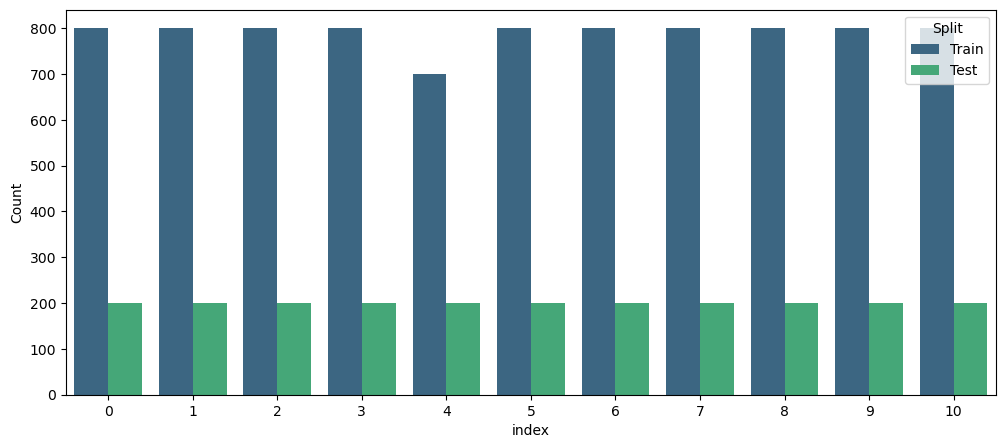

In [2]:
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Train': [Counter([l for _, l in train_dataset])[c] for c in range(n_classes)],
    'Test':  [Counter([l for _, l in test_dataset])[c]  for c in range(n_classes)]
}).melt(var_name='Split', value_name='Count', ignore_index=False).reset_index()

plt.figure(figsize=(12, 5)) # Keep just size so it's readable
sns.barplot(data=df, x='index', y='Count', hue='Split', palette="viridis")
plt.show()

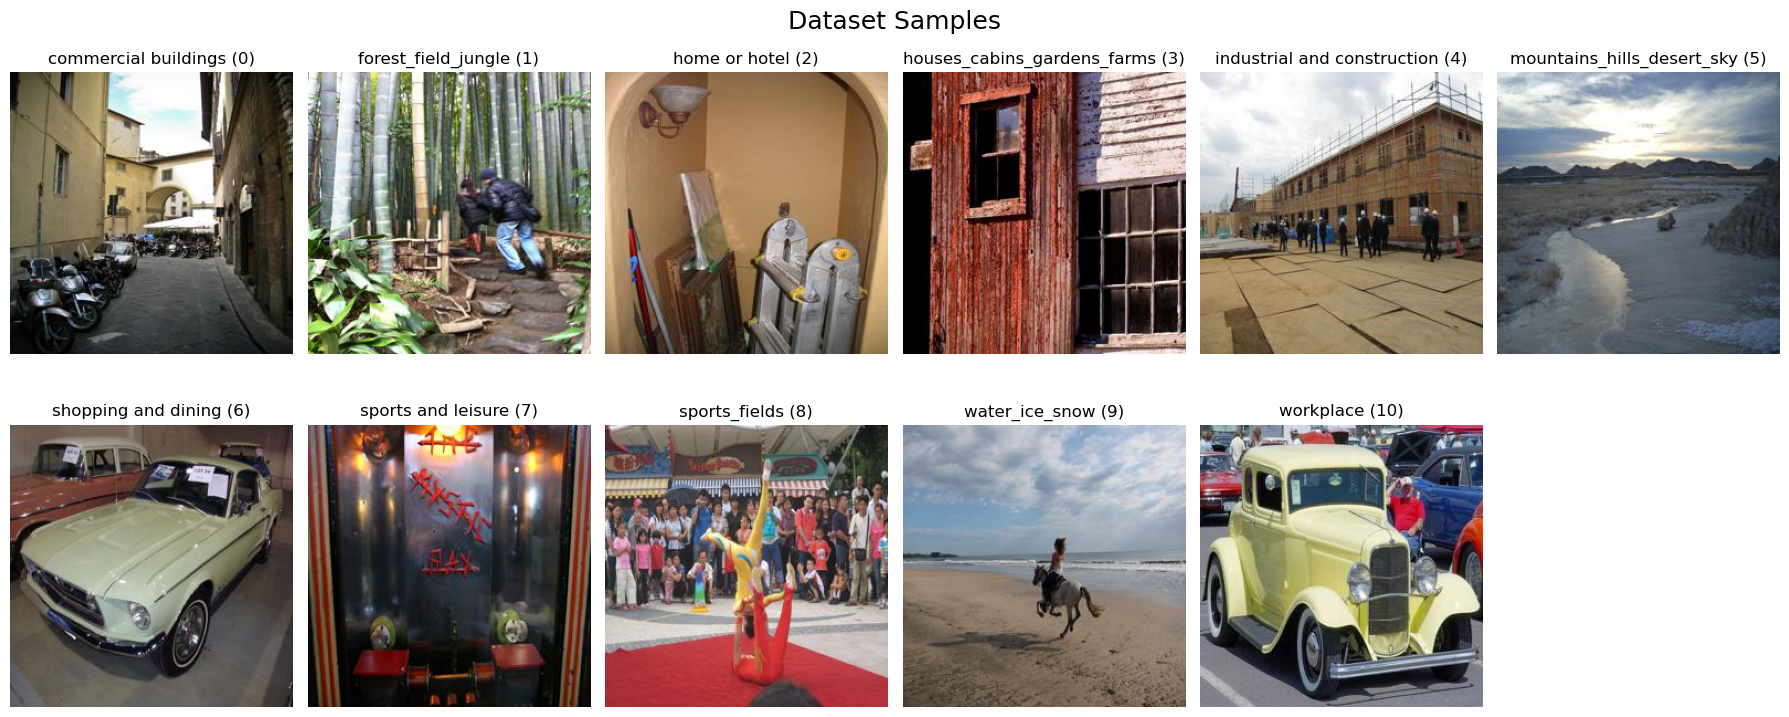

In [3]:
# Grid of images
cols = 6
rows = (n_classes + cols - 1) // cols

plt.figure(figsize=(18, 4 * rows))
plt.suptitle("Dataset Samples", fontsize=18, y=0.95)

seen_classes = set()
subplot_idx = 1

for img, label_idx in train_dataset:
    if label_idx not in seen_classes:
        seen_classes.add(label_idx)
        
        plt.subplot(rows, cols, subplot_idx)
        plt.imshow(img)
        plt.title(f"{class_names[label_idx]} ({label_idx})", fontsize=12)
        plt.axis('off')
        
        subplot_idx += 1
    
    if len(seen_classes) == n_classes:
        break

plt.tight_layout()
plt.show()

As observed in the grid above, we are working with a reduced subset of the Places365 dataset comprising 11 distinct scene categories.

Regarding the class distribution:
* Training Set: The dataset is nearly balanced. Most classes contain 800 images, with the exception of *"Industrial and Construction"* (Class 4), which contains 700 images.
* Test Set: The test set is perfectly balanced, featuring 200 images per class.

## Development


The core objective of this project is to construct a robust Bag of Visual Words (BoVW) classification system. The system's performance relies heavily on the quality of the feature extractors and the subsequent aggregation strategies. We adopt an incremental development strategy, starting from a simple baseline and progressively integrating advanced techniques based on hypothesis testing. This allows us to isolate the impact of each component (e.g., descriptor type, density, dimensionality).

We establish a baseline using a controlled environment: the SIFT detector, a limited number of features per image (500), and a small vocabulary size ($k=50$). This setup serves as a benchmark to compare the intrinsic performance of different descriptors.

In [2]:
small_CONFIG_ = {
    "data_path": "../data/MIT_split/",
    "seed": 42,
    
    # Features
    "detector": "SIFT",          # SIFT, ORB, AKAZE
    "detector_kwargs": {"nfeatures": 500},
    
    # BoVW
    "codebook_size": 50,

    # Classifier
    "classifier": "LogisticRegression",  # LogisticRegression, SVM-Linear, SVM-RBF
}

Throughout the experiments, we expand the system capabilities to test new hypotheses. The final pipeline supports:
- Feature Extraction: Dense SIFT vs. Keypoint Detection.
- Dimensionality Reduction: PCA to reduce descriptor size.
- Representation: Varying codebook sizes and Spatial Pyramid Matching (SPM).
- Preprocessing: L1/L2 Normalization and Scaling.
- Classification: Support Vector Machines (Linear/RBF) vs. Logistic Regression.

The configuration dictionary below reflects the full range of hyperparameters tested:

In [3]:
CONFIG = {
        "data_path": "../data/MIT_split/",
        "seed": 42,
        
        # Features
        "detector": "SIFT",          # SIFT, ORB, AKAZE
        "detector_kwargs": {"nfeatures": 500},
        
        "dense": False,
        "step_size": 8,              # Only for Dense
        "scale": 8,                  # Only for Dense
        
        # BoVW
        "codebook_size": 50,
        "spatial_pyramid": False,
        "levels": [1, 2],
        
        "use_pca": False,
        "pca_components": 64,

        "normalization": "l2", # l1, l2, none
        "scaler": None,        # StandardScaler, MinMaxScaler, None

        # Classifier
        "classifier": "LogisticRegression",  # LogisticRegression, SVM-Linear, SVM-RBF
        "C": 1.0,
        "gamma": "scale",

        "codebook_batch_size": 10000,
        
        # Debug
        "max_samples_train": None,
        "max_samples_test": None
    }

Last but not least, all experiments are evaluated using 5-fold Cross-Validation on the training set to ensure statistical robustness. Final design decisions and reported performance metrics are based on the Test set results.

### Imports and Functions

In [1]:
import os
import pandas as pd
from auxiliary_functions import *

os.makedirs("results", exist_ok=True)

### 1 - Feature Descriptors

In this initial experiment, we evaluate the performance of three distinct local feature descriptors: SIFT, ORB, and AKAZE. These are tested under the baseline configuration (500 features per image, codebook size 50).

Technical Note: While SIFT and ORB allow us to explicitly set the maximum number of retained features (n_features=500), AKAZE controls feature quantity via a detection threshold. For this experiment, we utilize the default threshold settings for AKAZE.

Hypothesis: We hypothesize that SIFT will achieve the highest classification accuracy.
- SIFT is a gradient-based descriptor widely recognized as the most robust option for scale, rotation, and affine variations.
- ORB is a binary descriptor designed for speed. While efficient, it is generally less accurate than SIFT for complex scene recognition, particularly with significant scale changes.
- AKAZE operates in a nonlinear scale space. While often superior to ORB, it typically does not match SIFT's discriminative power for general scene classification tasks.

In [5]:
config_path = "configs/local_descriptors.json"
results_path = "results/local_descriptors.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/local_descriptors.csv
Loaded 3 experiments from configs/local_descriptors.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0     SIFT (N=500)        0.302529       0.279545   
1      ORB (N=500)        0.204253       0.164545   
2  AKAZE (Default)        0.209655       0.179091   

                                           CV Scores    Time (s)  
0  [0.25632184 0.27298851 0.26321839 0.25057471 0...  255.485340  
1  [0.17126437 0.16781609 0.17413793 0.1637931  0...  133.185345  
2  [0.17586207 0.17701149 0.18045977 0.16666667 0...  150.267757

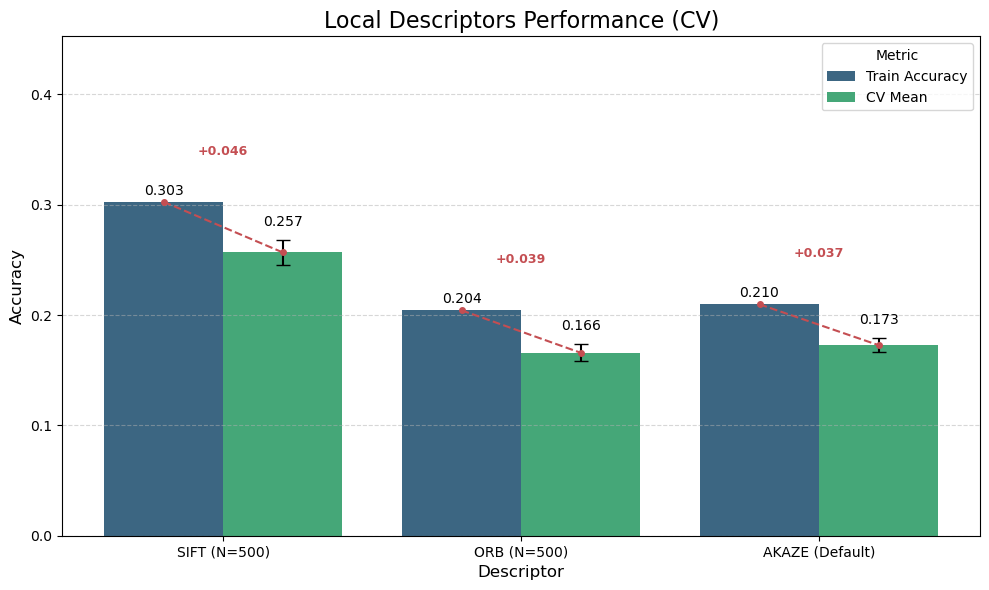

In [2]:
df = pd.read_csv("results/local_descriptors.csv")
plot_local_descriptors(df)

The results validate our hypothesis. SIFT demonstrates superior performance compared to ORB and AKAZE. The histograms used by SIFT capture more distinctive texture information than the binary comparisons used by ORB, which is crucial for distinguishing between semantic classes.

Trade-off: There is a clear trade-off regarding computational cost. SIFT is computationally expensive compared to the binary descriptors. However, as the primary objective of this project is to maximize classification accuracy rather than achieve real-time performance, we select SIFT as the baseline descriptor for all subsequent experiments.

### 2 - N Features of SIFT

In this experiment, we analyze how the maximum number of retained SIFT features per image affects classification performance. We vary the nfeatures parameter (e.g., 50, 100, 200, 500, 1000, 2000, 5000) while keeping the codebook size constant at 50.

Hypothesis: We hypothesize that increasing the limit of detected features will initially improve accuracy significantly. A higher number of features provides a denser and more informative description of the scene, reducing the sparsity of the resulting histograms. However, we expect the performance to plateau after a certain threshold. This is because SIFT filters keypoints based on contrast and edge responses. Once all distinct keypoints are captured, increasing the limit further will either add no new information (if the image is simple) or introduce less discriminative, noisy features.

In [9]:
config_path = "configs/sift_nfeatures.json"
results_path = "results/sift_nfeatures.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/sift_nfeatures.csv
Loaded 8 experiments from configs/sift_nfeatures.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0     SIFT (N=50)        0.232529       0.204091   
1    SIFT (N=100)        0.253333       0.230455   
2    SIFT (N=500)        0.302529       0.279545   
3   SIFT (N=1000)        0.312759       0.296818   
4   SIFT (N=1500)        0.318966       0.288182   
5   SIFT (N=3000)        0.310920       0.290909   
6   SIFT (N=5000)        0.310920       0.290909   
7  SIFT (N=10000)        0.310920       0.290909   

                                           CV Scores    Time (s)  
0  [0.20747126 0.20977011 0.18965517 0.16206897 0...  179.703144  
1  [0.22068966 0.2408046  0.2045977  0.18735632 0...  194.209655  
2  [0.25632184 0.27298851 0.26321839 0.25057471 0...   19.692358  
3  [0.26494253 0.3045977  0.25862069 0.24885057 0...  241.630604  
4  [0.27183908 0.29252874 0.27183908 0.25804598 0...  248.572399  
5  [0.27528736 0.30057471 0.26264368 0.25       0...  267.949265  
6  [0.27528736 0.30057471 0.26264368 0.25       0...  277.374228  
7  [0.27528736 0.30057471 0.26264368 0.25       0...  286.475468

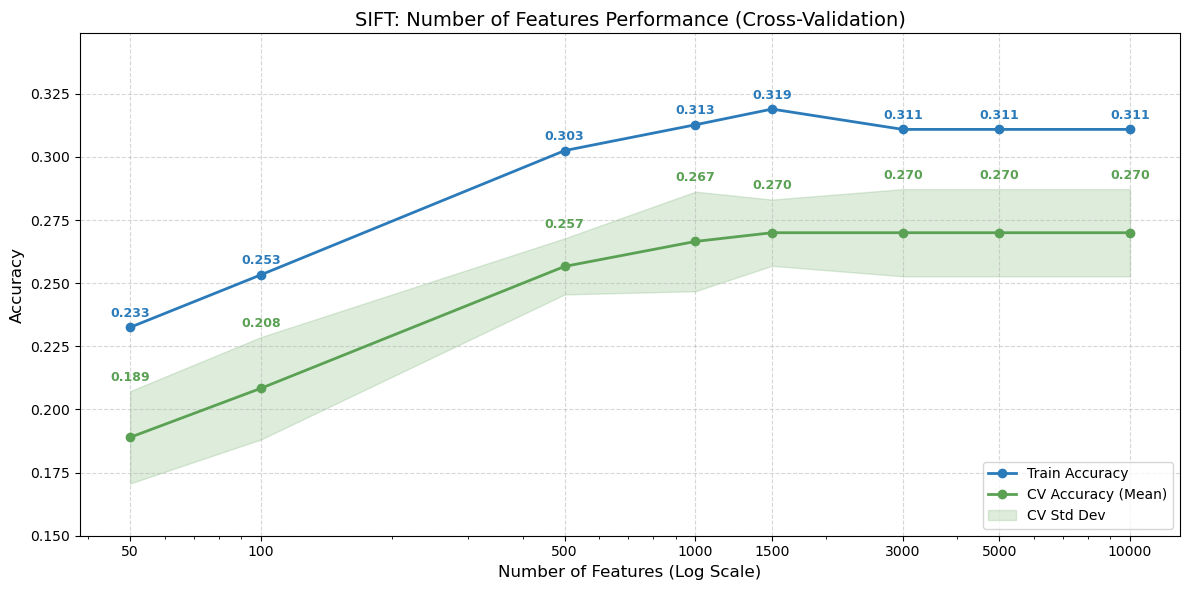

In [3]:
df = pd.read_csv("results/sift_nfeatures.csv")
plot_sift_nfeatures(df)

As observed in the plot, setting a low limit for feature detection results in poor performance. Accuracy improves consistently as we increase the number of features, as the image is described with higher granularity.

However, the performance gain diminishes significantly after 500 features and reaches a plateau around 1000 features (achieving a test accuracy of approximately 0.297). This plateau occurs because nfeatures acts as an upper limit. If the SIFT algorithm detects only 400 distinct keypoints in a smooth or low-texture image, raising the limit to 2000 will not force the creation of more features. Therefore, the results suggest that for the resolution and texture content of the Places365 subset, SIFT rarely extracts more than 1000 highly discriminative features per image.

Now, for all subsequent experiments involving SIFT, we will fix nfeatures = 1000 to ensure we capture the maximum amount of relevant information without incurring unnecessary computational overhead.

Question: Which is the descriptors role? The local descriptors are the fundamental building blocks of the BoVW model. Their role is to transform raw pixel data around a keypoint into a compact, invariant vector representation. In the context of categorization, having a sufficient quantity of descriptors is crucial to ensure that the generated visual word histogram statistically represents the image content accurately. If too few descriptors are used, the histogram becomes too sparse to be discriminative.

### 3 - Dense SIFT

In this section, we implement Dense SIFT, a variation where descriptors are computed on a regular grid rather than at specific keypoints detected by an algorithm. This approach is particularly useful for scene classification, as it captures information from uniform regions (like sky, roads, or calm water) that standard detectors often ignore.

Unlike standard SIFT, the number of features is not fixed but depends on the image resolution and two sampling parameters:
- Step Size: The distance (in pixels) between consecutive grid centers. We test values: [4, 8, 16, 32].
- Scale Factor: A divisor used to determine the diameter of the SIFT descriptor relative to the step size ($KeypointSize = StepSize / ScaleFactor$). We test factors: [1, 2, 4].

Hypothesis: We hypothesize that smaller step sizes (e.g., 4 or 8) will yield higher classification accuracy compared to larger steps (e.g., 32). A denser grid captures fine-grained texture details essential for distinguishing semantic categories. Regarding the scale, we define the feature size to be equal to or smaller than the step size (Factors $\ge 1$) to avoid spatial overlap. While overlap can provide invariance, in this specific experiment, we aim to minimize redundant information to keep the feature set concise.

We visualize the grid configurations below to understand the density differences:

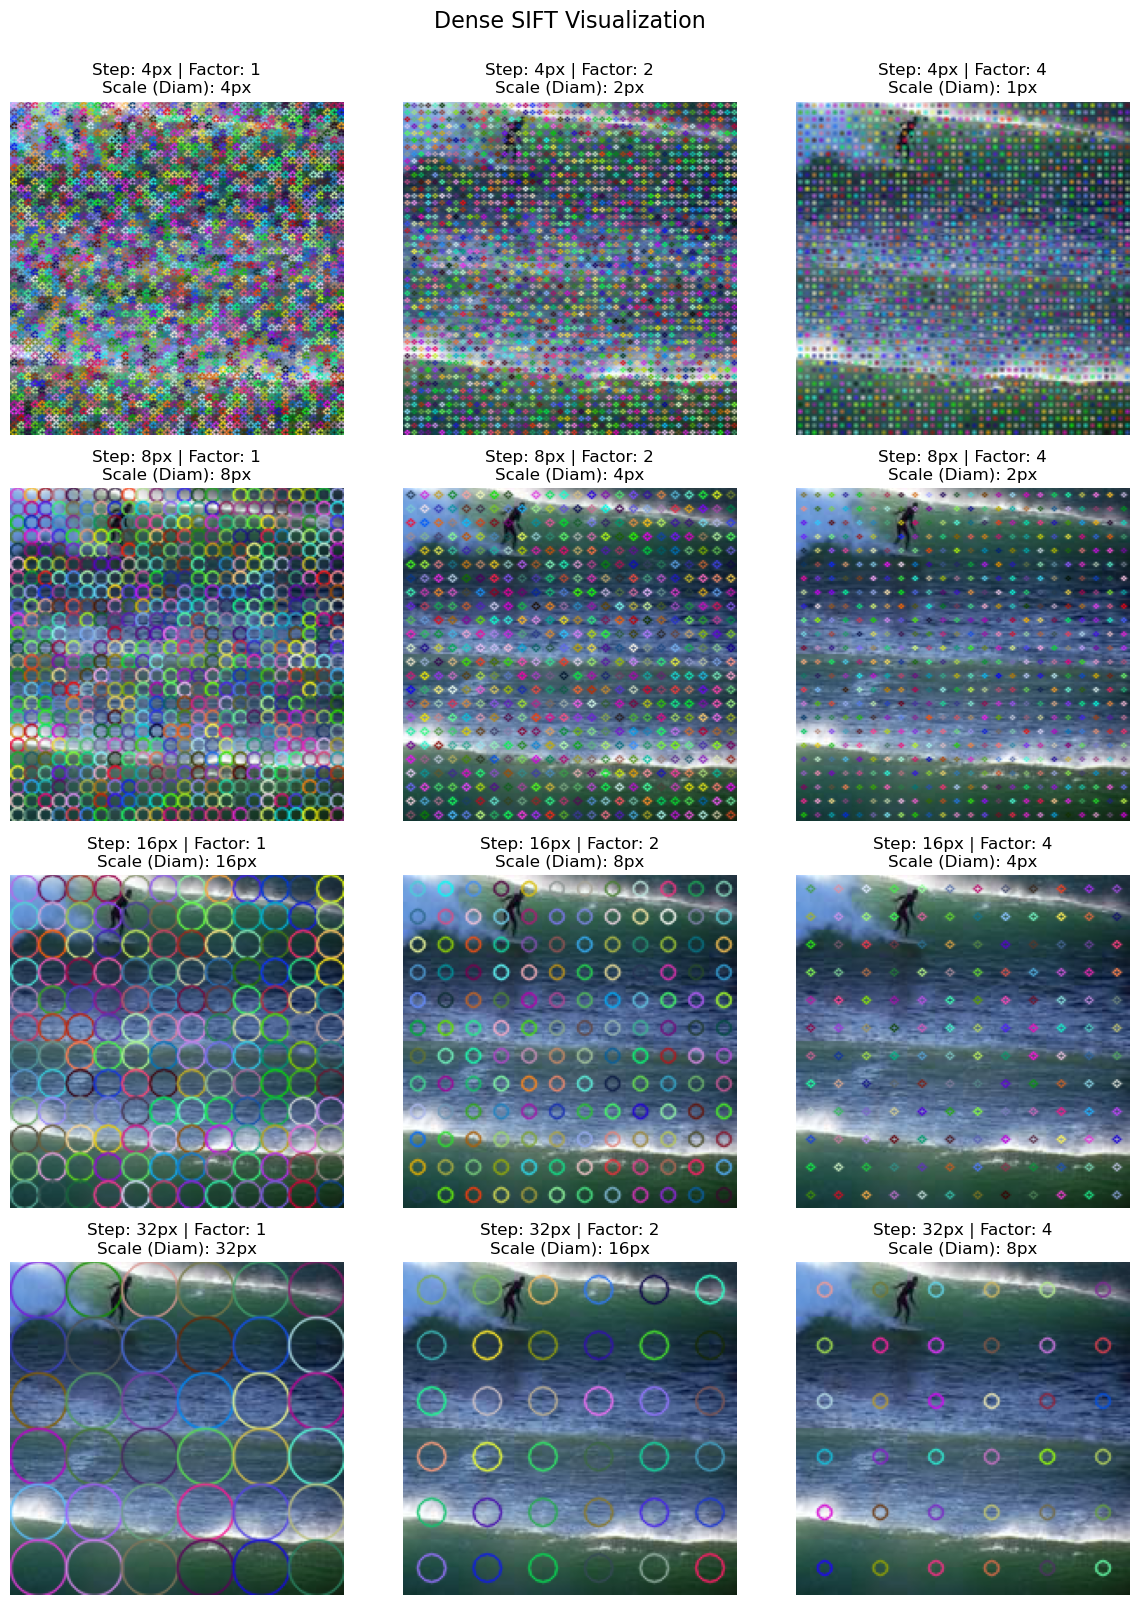

In [11]:
from plots import *
sample_image = "../data/MIT_split/train/water_ice_snow/beach_00000758.jpg" 

STEPS = [4, 8, 16, 32]
FACTORS = [1, 2, 4]  # Denominators as per your request

visualize_dense_sift_grid(sample_image, STEPS, FACTORS)

In [12]:
config_path = "configs/dense_sift.json"
results_path = "results/dense_sift.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/dense_sift.csv
Loaded 12 experiments from configs/dense_sift.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Step Size  Scale Factor  Scale  Train Accuracy  \
0     Dense (Step=4, Scale=4)          4             1      4        0.340115   
1     Dense (Step=4, Scale=2)          4             2      2        0.332874   
2     Dense (Step=4, Scale=1)          4             4      1        0.333908   
3     Dense (Step=8, Scale=8)          8             1      8        0.335632   
4     Dense (Step=8, Scale=4)          8             2      4        0.330690   
5     Dense (Step=8, Scale=2)          8             4      2        0.330690   
6   Dense (Step=16, Scale=16)         16             1     16        0.309885   
7    Dense (Step=16, Scale=8)         16             2      8        0.341609   
8    Dense (Step=16, Scale=4)         16             4      4        0.322184   
9   Dense (Step=32, Scale=32)         32             1     32        0.269425   
10  Dense (Step=32, Scale=16)         32             2     16        0.313333   
11   Dense (Step=32, Scale=8)         32             4      8        0.309885   

    Test Accuracy                                          CV Scores  \
0        0.318636  [0.29885057 0.31206897 0.29655172 0.2637931  0...   
1        0.320455  [0.2862069  0.29655172 0.2954023  0.28448276 0...   
2        0.303636  [0.28275862 0.30402299 0.30229885 0.27643678 0...   
3        0.317273  [0.30114943 0.30862069 0.27988506 0.27988506 0...   
4        0.314545  [0.28563218 0.2954023  0.28045977 0.26896552 0...   
5        0.305909  [0.28735632 0.2908046  0.27586207 0.27298851 0...   
6        0.286364  [0.25172414 0.27471264 0.25804598 0.25344828 0...   
7        0.326364  [0.30344828 0.30574713 0.27873563 0.27873563 0...   
8        0.307727  [0.27988506 0.29137931 0.26436782 0.26436782 0...   
9        0.249545  [0.20747126 0.22758621 0.20057471 0.22356322 0...   
10       0.286818  [0.25977011 0.27643678 0.26149425 0.27068966 0...   
11       0.294091  [0.27356322 0.27241379 0.25344828 0.2362069  0...   

      Time (s)  
0   159.311387  
1   178.203363  
2   190.247833  
3   164.183686  
4   140.163619  
5   161.616699  
6   142.903489  
7   138.050523  
8   145.223500  
9   104.779328  
10   97.214594  
11   97.909184

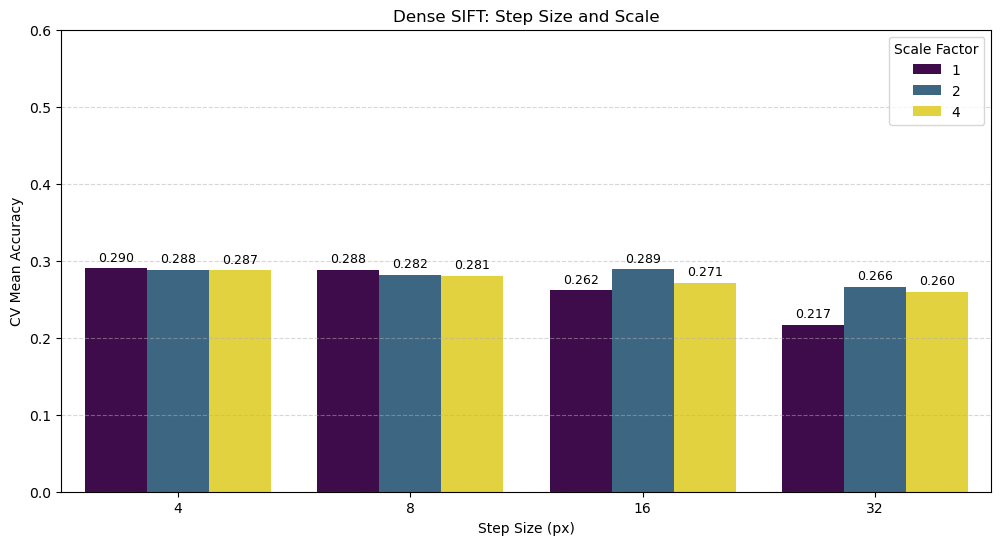

In [2]:
df = pd.read_csv("results/dense_sift.csv")
plot_dense_sift_step_size_scale(df)

The results graph indicates a clear trend:
1. Performance Saturation: Step sizes of 4, 8, and 16 perform similarly, suggesting that capturing features every 4 pixels provides diminishing returns compared to every 8 or 16 pixels for this specific image resolution ($256 \times 256$).
2. Under-sampling: A step size of 32 results in a significant drop in accuracy. At this sparsity, the grid fails to capture enough texture information to represent the scene adequately.
3. Best Configuration: Interestingly, the specific combination of Step Size 16 with Scale Factor 2 achieves the highest accuracy (0.33). This suggests that for a codebook size of $k=50$, a moderately sparse grid with smaller, non-overlapping features provides a distinct enough vocabulary without introducing noise.

Therefore, Dense SIFT outperforms the standard Keypoint-SIFT baseline (which peaked at 0.297). The absolute improvement is approximately 3.3%, confirming that for scene classification, dense sampling is generally superior to interest-point detection.

An important point to make is that while accuracy is paramount, practical deployment requires analyzing computational cost. A step size of 4 generates roughly $64 \times$ more features than a step size of 32, drastically increasing memory usage and clustering time.

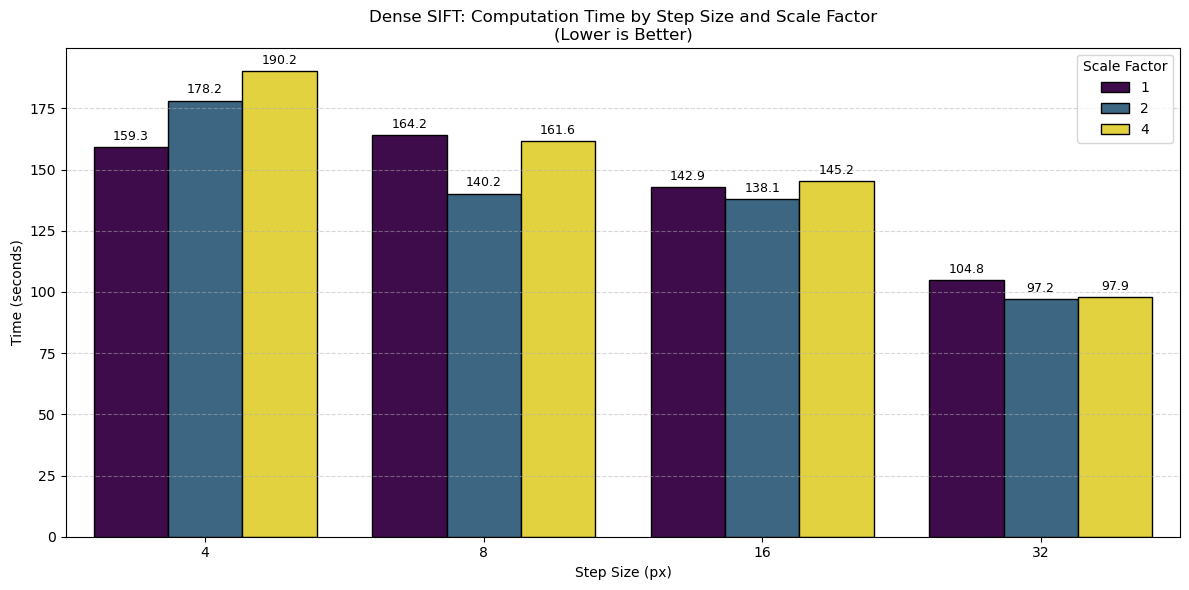

In [3]:
df = pd.read_csv("results/dense_sift.csv")
plot_dense_sift_times(df)

As shown in the time plot, the computational cost grows exponentially as the step size decreases.
- Step Size 4: Extremely expensive (high execution time) with marginal accuracy gains over Step 8.
- Step Size 8: Offers a balanced compromise between feature density and processing speed.

So, our decision for the subsequent experiments is that we will proceed with Step Size 8 (Scale Factor 1) and Step Size 16 (Scale Factor 2). These configurations provide a robust accuracy baseline while keeping the pipeline computationally feasible for more complex tasks like PCA reduction or Spatial Pyramids.

Question: Does scale play any role? Yes, scale is a critical determinant of performance in Dense SIFT. Unlike standard SIFT, which automatically estimates the intrinsic scale of a keypoint (providing scale invariance), Dense SIFT operates at fixed, predefined scales.

### 4 - Codebook Size

In this experiment, we evaluate the system's performance by varying the vocabulary size ($k$) across three distinct feature extraction configurations:
- Baseline SIFT: (n_features=1000)
- Dense SIFT A: (step_size=16, scale_factor=2) - The current leader.
- Dense SIFT B: (step_size=8, scale_factor=1)

Hypothesis and Theoretical Implications: We hypothesize that Dense SIFT (Step 8) will outperform the other configurations as $k$ increases. Since this configuration generates a significantly higher volume of descriptors, it requires a larger vocabulary to effectively quantize the feature space without losing information.

Question: Which is the impact on performance of each parameter? Regarding the codebook size specifically:
- Small $k$ (Underfitting): Visual words become too generic. Distinct visual features (e.g., a wheel and a clock) might be assigned to the same cluster, reducing discriminative power.
- Large $k$ (Overfitting): Allows for fine-grained distinctions but increases the dimensionality of the final histogram. If $k$ is too large, the system may cluster noise or irrelevant details, leading to sparse histograms and overfitting on the training data.

In [16]:
config_path = "configs/codebook_size_all.json"
results_path = "results/codebook_size_all.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/codebook_size_all.csv
Loaded 21 experiments from configs/codebook_size_all.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0                SIFT (k=10)        0.219425       0.216364   
1                SIFT (k=50)        0.315632       0.298636   
2               SIFT (k=100)        0.348391       0.314091   
3               SIFT (k=200)        0.380805       0.332727   
4               SIFT (k=500)        0.446552       0.328182   
5              SIFT (k=1000)        0.505057       0.336364   
6              SIFT (k=2000)        0.581494       0.330455   
7      Dense SIFT 8x8 (k=10)        0.259195       0.246364   
8      Dense SIFT 8x8 (k=50)        0.345287       0.326818   
9     Dense SIFT 8x8 (k=100)        0.373448       0.350000   
10    Dense SIFT 8x8 (k=200)        0.414368       0.367727   
11    Dense SIFT 8x8 (k=500)        0.464828       0.396364   
12   Dense SIFT 8x8 (k=1000)        0.516437       0.392273   
13   Dense SIFT 8x8 (k=2000)        0.574828       0.395000   
14    Dense SIFT 16x8 (k=10)        0.252989       0.243636   
15    Dense SIFT 16x8 (k=50)        0.331954       0.305000   
16   Dense SIFT 16x8 (k=100)        0.362529       0.335455   
17   Dense SIFT 16x8 (k=200)        0.404483       0.357273   
18   Dense SIFT 16x8 (k=500)        0.472069       0.354091   
19  Dense SIFT 16x8 (k=1000)        0.523908       0.370455   
20  Dense SIFT 16x8 (k=2000)        0.586092       0.368182   

                                            CV Scores    Time (s)  
0   [0.17931034 0.20517241 0.20574713 0.19655172 0...   92.636992  
1   [0.25057471 0.30114943 0.2637931  0.25689655 0...   34.986966  
2   [0.27413793 0.30287356 0.27471264 0.26609195 0...   36.221768  
3   [0.29425287 0.31724138 0.29367816 0.25574713 0...   35.327341  
4   [0.30114943 0.33218391 0.30632184 0.29770115 0...   43.525740  
5   [0.30057471 0.34195402 0.31609195 0.28390805 0...   55.988386  
6   [0.30747126 0.33103448 0.31091954 0.28965517 0...   77.770330  
7   [0.22183908 0.26321839 0.23218391 0.22873563 0...   45.169032  
8   [0.30517241 0.30977011 0.28850575 0.27988506 0...   52.400569  
9   [0.32241379 0.33218391 0.29597701 0.30632184 0...   57.796695  
10  [0.32758621 0.33735632 0.31609195 0.31206897 0...   61.773374  
11  [0.32528736 0.34195402 0.33103448 0.31494253 0...   74.337271  
12  [0.32643678 0.36149425 0.33045977 0.32413793 0...   92.220221  
13  [0.34712644 0.36149425 0.33448276 0.32586207 0...  142.055849  
14  [0.22126437 0.24712644 0.22471264 0.2137931  0...   24.265968  
15  [0.2908046  0.30344828 0.27068966 0.28103448 0...   26.041830  
16  [0.29022989 0.30632184 0.27758621 0.28965517 0...   27.239259  
17  [0.31724138 0.32643678 0.29885057 0.29942529 0...   29.806438  
18  [0.33275862 0.3362069  0.30574713 0.30172414 0...   35.822803  
19  [0.32758621 0.32758621 0.30114943 0.3091954  0...   44.746189  
20  [0.31666667 0.35229885 0.3045977  0.31321839 0...   64.658182

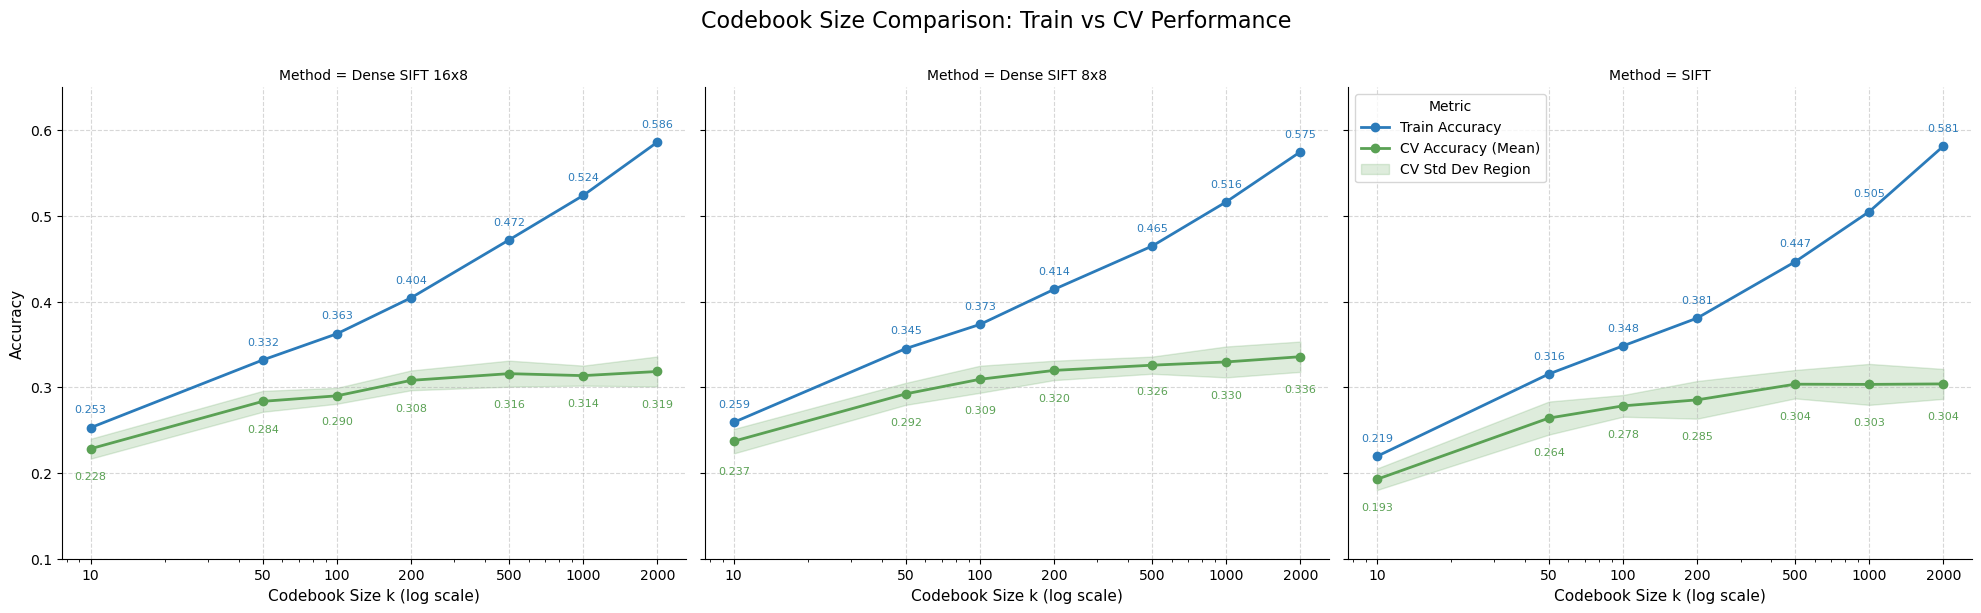

In [4]:
df = pd.read_csv("results/codebook_size_all.csv")
plot_codebook_size(df)

The results validate our hypothesis regarding feature density, while highlighting a critical trade-off regarding vocabulary capacity:
1. Top Performance: The Dense SIFT (Step 8, Scale 1) configuration consistently yields better Cross-Validation (CV) accuracy compared to Step 16 or regular SIFT. This confirms that the denser sampling strategy successfully captures the fine-grained details necessary for discriminating between complex scene categories.
2. The "Sweet Spot" vs. Overfitting: We identify $k=200$ as the optimal "sweet spot" for our codebook size, balancing model complexity with generalization:
    - Overfitting at Large $k$ ($>200$): Increasing $k$ further to 500 or 1000 results in significant overfitting. While training accuracy might remain high, the model begins to "memorize" the training data rather than generalizing, resulting in stagnant CV accuracy on unseen data. Theoretically, if $k$ is too large relative to the feature count, the system begins clustering noise, leading to high-dimensional, overly sparse histograms.
    - Underfitting at Small $k$: Conversely, smaller codebook sizes risk underfitting. When $k$ is too small, the visual words become too generic; distinct visual features (e.g., a wheel vs. a clock) are forced into the same cluster, causing a loss of discriminative power.

So, our final decision is that $k=200$ provides the most competitive accuracy before the computational cost and risk of overfitting surpass the marginal performance gains. Therefore, we will adopt Dense SIFT (Step 8, Scale Factor 1) with $k=200$ as our primary feature extractor for subsequent experiments. We will also retain standard SIFT with $k=200$ as a comparative baseline.

### 5 - Dimensionality Reduction

Dense SIFT generates a massive volume of descriptors. In this experiment, we apply Principal Component Analysis (PCA) to the local descriptors before the vocabulary learning stage. We test reducing the SIFT descriptor dimensionality from the original dimensions to varying components: [16, 32, 64, 128].

Hypothesis: PCA filters noise and redundancy, potentially improving performance. However, we anticipate a 'tipping point' where excessive reduction discards essential structure, causing a drastic drop in accuracy."

In [11]:
config_path = "configs/dim_reduction_8x8.json"
results_path = "results/dim_reduction_8x8_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/dim_reduction_8x8_200.csv
Loaded 16 experiments from configs/dim_reduction_8x8.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0           SIFT (pca_components=1)        0.260345       0.185000   
1           SIFT (pca_components=2)        0.297816       0.225000   
2           SIFT (pca_components=4)        0.344138       0.284091   
3           SIFT (pca_components=8)        0.365632       0.320000   
4          SIFT (pca_components=16)        0.376897       0.310909   
5          SIFT (pca_components=32)        0.386782       0.314545   
6          SIFT (pca_components=64)        0.386437       0.329545   
7         SIFT (pca_components=128)        0.380805       0.331364   
8     Dense SIFT (pca_components=1)        0.246092       0.185909   
9     Dense SIFT (pca_components=2)        0.293563       0.226818   
10    Dense SIFT (pca_components=4)        0.371264       0.308182   
11    Dense SIFT (pca_components=8)        0.404598       0.348182   
12   Dense SIFT (pca_components=16)        0.411609       0.380909   
13   Dense SIFT (pca_components=32)        0.412989       0.362273   
14   Dense SIFT (pca_components=64)        0.412874       0.375909   
15  Dense SIFT (pca_components=128)        0.413563       0.368636   

                                            CV Scores    Time (s)  
0   [0.18850575 0.19367816 0.16149425 0.18390805 0...  128.231238  
1   [0.19827586 0.23448276 0.22471264 0.19655172 0...   63.190032  
2   [0.25229885 0.27586207 0.25057471 0.24137931 0...   63.279991  
3   [0.26551724 0.30747126 0.28333333 0.26264368 0...   60.567853  
4   [0.27586207 0.3        0.28333333 0.28678161 0...   60.036572  
5   [0.2908046  0.32758621 0.29482759 0.28448276 0...   65.038056  
6   [0.2862069  0.31954023 0.29482759 0.27241379 0...   66.381793  
7   [0.29367816 0.31666667 0.2954023  0.25632184 0...   71.288781  
8   [0.19137931 0.19367816 0.18563218 0.18678161 0...  192.187315  
9   [0.22471264 0.2316092  0.22643678 0.19770115 0...   96.708943  
10  [0.27758621 0.29252874 0.26724138 0.27011494 0...   98.698942  
11  [0.31666667 0.3316092  0.28678161 0.29942529 0...  100.320694  
12  [0.31781609 0.32758621 0.30229885 0.30114943 0...  103.043902  
13  [0.32183908 0.32758621 0.30632184 0.29827586 0...  106.974437  
14  [0.31609195 0.33218391 0.30287356 0.3        0...  113.791654  
15  [0.32873563 0.33678161 0.31551724 0.31149425 0...  130.613554

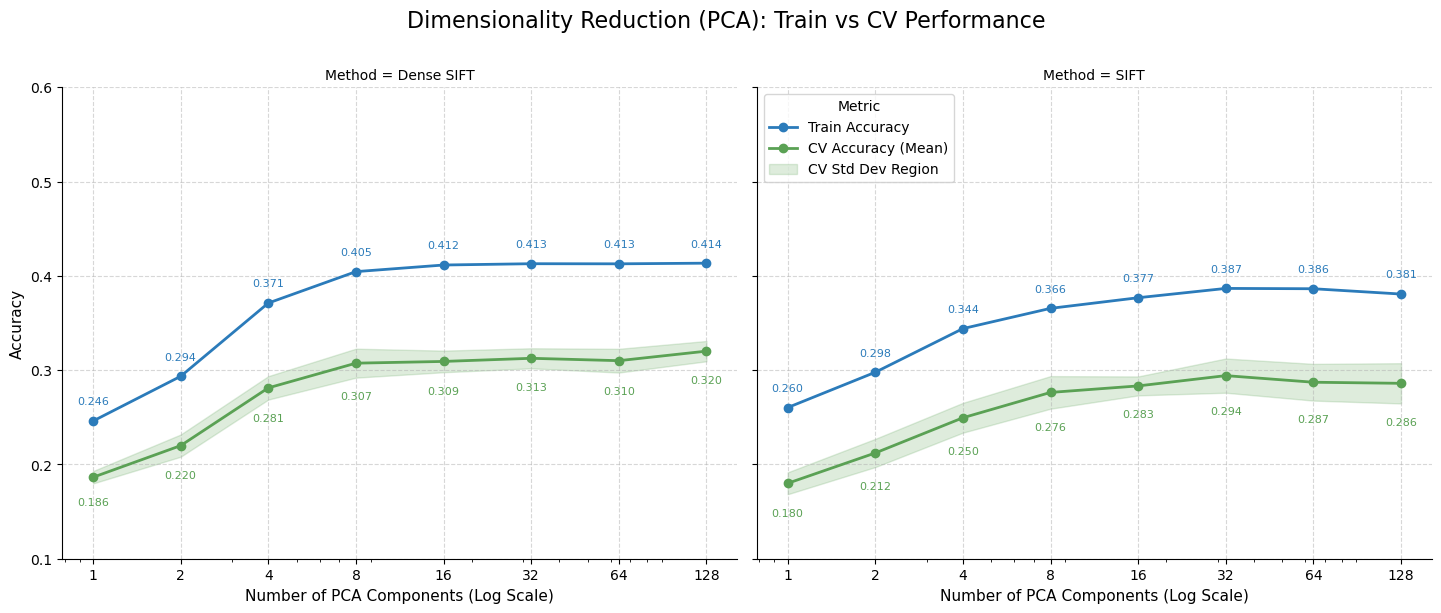

In [5]:
df = pd.read_csv("results/dim_reduction_8x8_200.csv")
plot_dim_reduction(df)

Question: Which is the impact on performance of each parameter? (Results & Analysis) The impact of dimensionality reduction proved to be dependent on the descriptor extraction method:
- Standard SIFT (Sparse): Hypothesis Validated. Accuracy peaks at 32 components (0.294) versus the baseline (0.285). 
    - Reasoning: Sparse keypoints often overlap significantly. In this context, PCA effectively removes redundancy and noise, resulting in a cleaner signal for clustering.

- Dense SIFT (Grid): Hypothesis Refuted. Performance stabilizes around 8-D but never outperforms the raw input.
    - Reasoning: Dense descriptors capture distinct texture information across a regular grid. This data is inherently less redundant than overlapping sparse keypoints. Therefore, reducing dimensions deletes valid texture information rather than just noise.

Our final decision is based on these results. We will diverge our approach for the two methods:
- Dense SIFT: Proceed with the Full Descriptor (No PCA) to maximize texture retention.
- Standard SIFT: Apply PCA (32-D) for the comparative baseline.

### 6 - Normalization and Scaling

Raw histogram counts in the Bag of Visual Words (BoVW) model are often biased by image complexity. An image with many details generates significantly more features than a simple one, leading to different histogram magnitudes for the same semantic category.

In this experiment, we test different strategies to make these distributions comparable:
- Normalization: "None", "L1" (Manhattan), "L2" (Euclidean).
- Scaling: "None", "Standard Scaling" (z-score), "MinMax Scaling" (0-1 range).

Hypothesis: Raw histogram counts are biased by image complexity. We hypothesize that normalizing distributions and scaling feature ranges will make distinct images comparable and improve classifier convergence. Without normalization, the 'magnitude' of the histogram dominates the 'shape' of the distribution.

In [20]:
config_path = "configs/norm_scale_8x8.json"
results_path = "results/norm_scale_8x8_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/norm_scale_8x8_200.csv
Loaded 18 experiments from configs/norm_scale_8x8.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0             SIFT_None_None        0.402989       0.305000   
1               SIFT_L2_None        0.386782       0.314545   
2               SIFT_L1_None        0.267126       0.246818   
3           SIFT_L2_Standard        0.399080       0.298182   
4           SIFT_L1_Standard        0.388851       0.285455   
5         SIFT_None_Standard        0.402989       0.305000   
6             SIFT_L2_MinMax        0.396207       0.298636   
7             SIFT_L1_MinMax        0.368046       0.294545   
8           SIFT_None_MinMax        0.395402       0.311818   
9       Dense_SIFT_None_None        0.441149       0.363182   
10        Dense_SIFT_L2_None        0.414368       0.367727   
11        Dense_SIFT_L1_None        0.315517       0.305000   
12    Dense_SIFT_L2_Standard        0.442759       0.362727   
13    Dense_SIFT_L1_Standard        0.441264       0.364091   
14  Dense_SIFT_None_Standard        0.441264       0.364091   
15      Dense_SIFT_L2_MinMax        0.430690       0.369091   
16      Dense_SIFT_L1_MinMax        0.422529       0.365455   
17    Dense_SIFT_None_MinMax        0.422529       0.365455   

                                            CV Scores    Time (s)  
0   [0.27931034 0.28563218 0.2862069  0.26781609 0...  147.106398  
1   [0.2908046  0.32758621 0.29482759 0.28448276 0...   71.402752  
2   [0.22471264 0.25344828 0.26264368 0.22413793 0...   76.797912  
3   [0.26436782 0.29310345 0.28103448 0.26264368 0...   77.896983  
4   [0.26551724 0.2908046  0.27643678 0.25574713 0...   79.304473  
5   [0.27988506 0.28563218 0.2862069  0.26724138 0...   77.314182  
6   [0.27758621 0.30229885 0.29252874 0.27298851 0...   82.907744  
7   [0.27471264 0.29885057 0.27701149 0.24827586 0...   79.622970  
8   [0.28850575 0.30172414 0.29252874 0.26551724 0...   84.010119  
9   [0.33850575 0.32183908 0.30632184 0.31436782 0...   44.836232  
10  [0.32758621 0.33735632 0.31609195 0.31206897 0...   39.201991  
11  [0.26494253 0.2862069  0.28333333 0.26264368 0...   39.867591  
12  [0.33908046 0.31666667 0.30229885 0.31896552 0...   42.162884  
13  [0.33678161 0.32126437 0.30747126 0.31724138 0...   42.002465  
14  [0.33678161 0.32126437 0.30747126 0.31724138 0...   42.213615  
15  [0.33678161 0.33908046 0.31551724 0.32356322 0...   44.942380  
16  [0.32931034 0.33850575 0.31896552 0.31896552 0...   44.625151  
17  [0.32931034 0.33850575 0.31896552 0.31896552 0...   45.555358

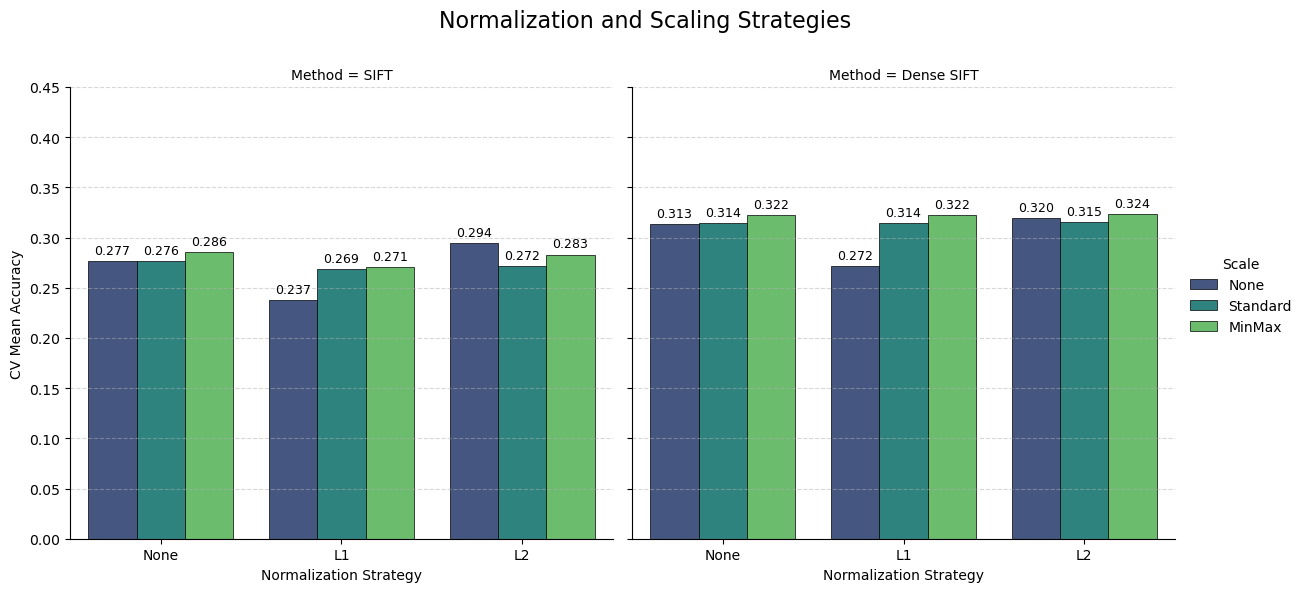

In [21]:
df = pd.read_csv("results/norm_scale_8x8_200.csv")
plot_norm_scale(df)

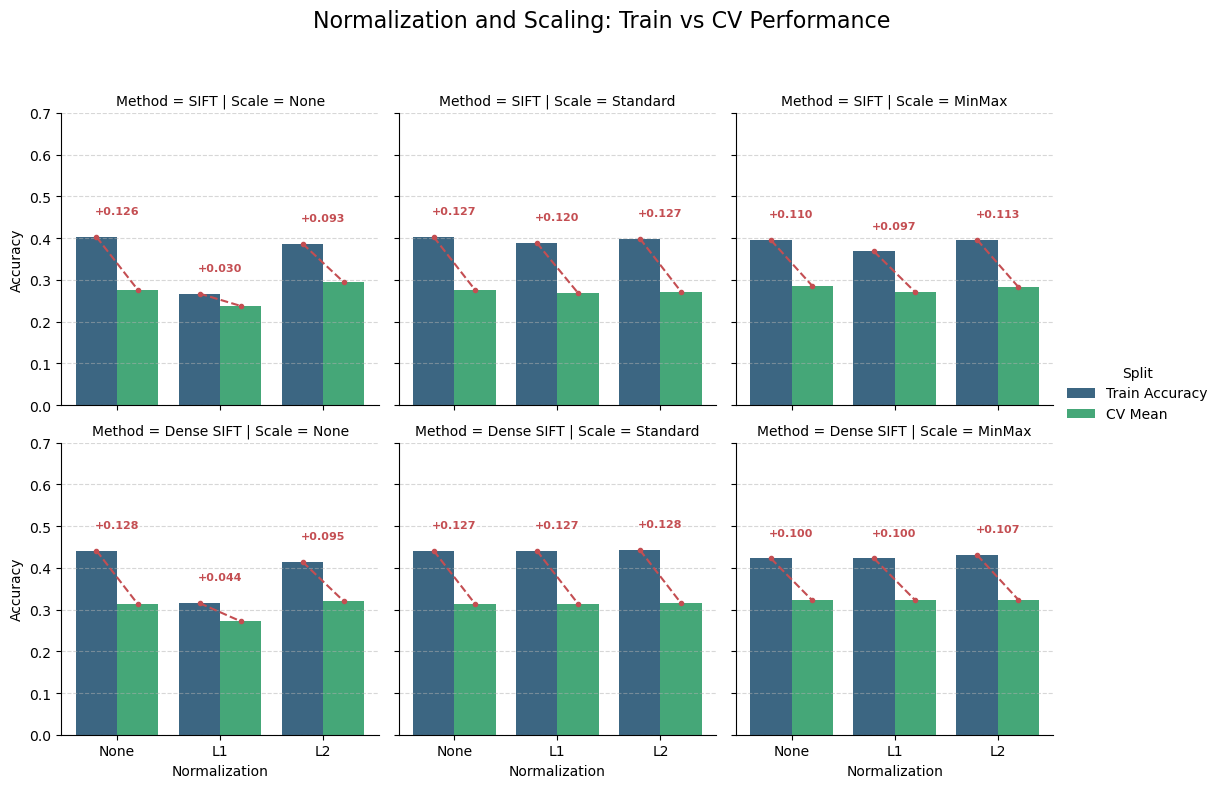

In [23]:
df = pd.read_csv("results/norm_scale_8x8_200.csv")
plot_norm_scale_v2(df)

Question: Which is the impact on performance of each parameter? (Results & Analysis) The results reveal that the optimal strategy depends heavily on the sparsity of the histograms:
- Standard SIFT (Sparse): L2 Normalization Only. The highest accuracy (0.294) is achieved using L2 Normalization with No Scaling. What we were already doing.
    - Insight: Standard SIFT produces sparse histograms with many empty bins and occasional outliers. Aggressive scaling techniques (like MinMax) tend to distort the data structure by amplifying small variations in these sparse vectors, which explains why adding  scaling drops performance (e.g., L2 + Standard Scale drops to 0.272). L1 normalization performed poorly (0.237), likely because it does not penalize large distinct peaks as effectively as L2.
- Dense SIFT (Grid): L2 Normalization + MinMax Scaling. The best performance (0.324) is achieved combining L2 Normalization with MinMax Scaling.
    - Insight: Unlike Standard SIFT, Dense sampling produces fully populated histograms. MinMax scaling is beneficial here because it ensures all bins are strictly bound to the $[0, 1]$ range. This prevents high-frequency visual words (common textures) from dominating the distance metrics used by the SVM, allowing the model to pay attention to subtler features.
    
In conclusion, we will adopt this results to the split strategy for the final pipeline process: 
- Standard SIFT: Apply L2 Normalization (No Scaling).
- Dense SIFT: Apply L2 Normalization followed by MinMax Scaling.

### 7 - Spatial Pyramid

Up to this point, our Bag of Visual Words model has been an "orderless" representation: it counts the frequency of visual words but completely discards their location within the image. To address this limitation, we implement Spatial Pyramids. SP works by partitioning the image into increasingly fine sub-regions (grids) at different levels (e.g., Level 0 is the whole image, Level 1 is a 2x2 grid, Level 2 is a 4x4 grid). A histogram is computed for each sub-region, and all histograms are concatenated to form the final feature vector.

Hypothesis: We hypothesize that increasing the pyramid levels will improve classification performance. By encoding rough spatial information, the model should be able to distinguish scenes with similar texture content but different layouts (e.g., distinguishing a "Coast" from an "Open Country" based on the position of the horizon or sky).

We evaluate this using levels [1, 2, 3] on our two best configurations:
- Baseline SIFT (n_features=1000 + k=200 + PCA with 32 components)
- Dense SIFT (Step 8 and Scale Factor 1 + k=200 + MinMax Scaling)

The following is an example of what the spatial pyramid does:

--- Visualizing 3 Levels ---


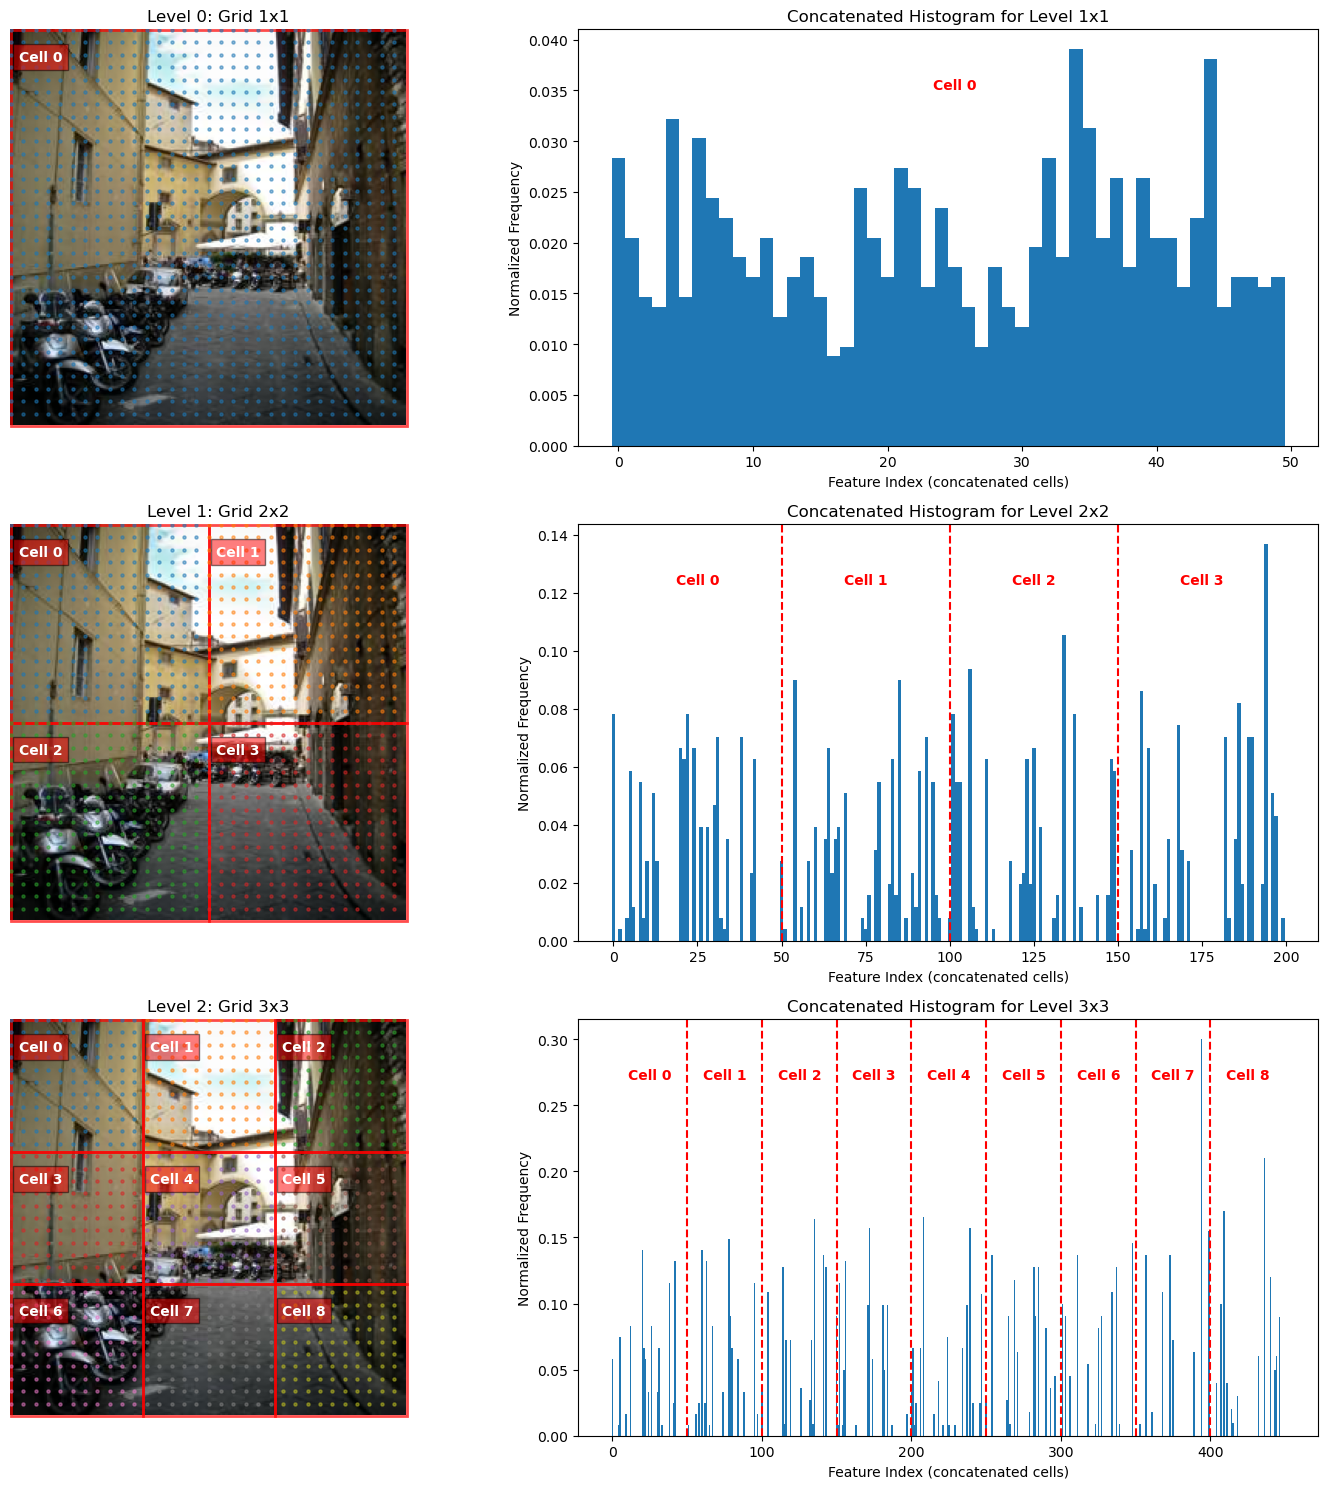

In [3]:
from bovw import BOVW

my_bovw = BOVW(
    detector_type="SIFT", dense=True, step_size=8, 
    scale=8, codebook_size=50, levels=[1, 2, 3]
)

test_image_path = "../data/MIT_split/train/commercial buildings/alley_00000100.jpg" 

visualize_spatial_pyramid(test_image_path, my_bovw)

In [28]:
config_path = "configs/spatial_pyramid.json"
results_path = "results/spatial_pyramid_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/spatial_pyramid_200.csv
Loaded 6 experiments from configs/spatial_pyramid.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0  Dense SIFT (L1)        0.430690       0.369091   
1  Dense SIFT (L2)        0.586322       0.364545   
2  Dense SIFT (L3)        0.955517       0.331818   
3        SIFT (L1)        0.386782       0.314545   
4        SIFT (L2)        0.452069       0.343182   
5        SIFT (L3)        0.504943       0.354091   

                                           CV Scores    Time (s)  
0  [0.33678161 0.33908046 0.31551724 0.32356322 0...   52.722822  
1  [0.32183908 0.30517241 0.31091954 0.30114943 0...   72.428860  
2  [0.29425287 0.28908046 0.27931034 0.28563218 0...  102.424548  
3  [0.2908046  0.32758621 0.29482759 0.28448276 0...   83.551742  
4  [0.28965517 0.32356322 0.30862069 0.29597701 0...   98.282664  
5  [0.29597701 0.33735632 0.30689655 0.30344828 0...  127.228251

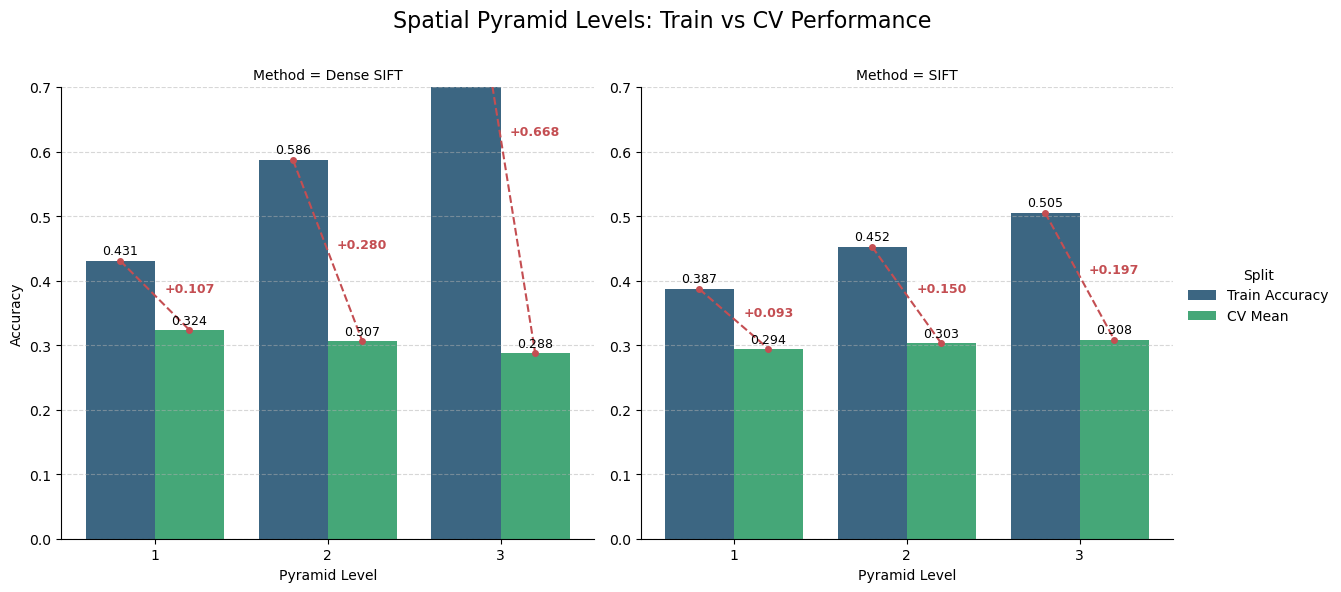

In [27]:
df = pd.read_csv("results/spatial_pyramid_200.csv")
plot_spatial_pyramid(df)

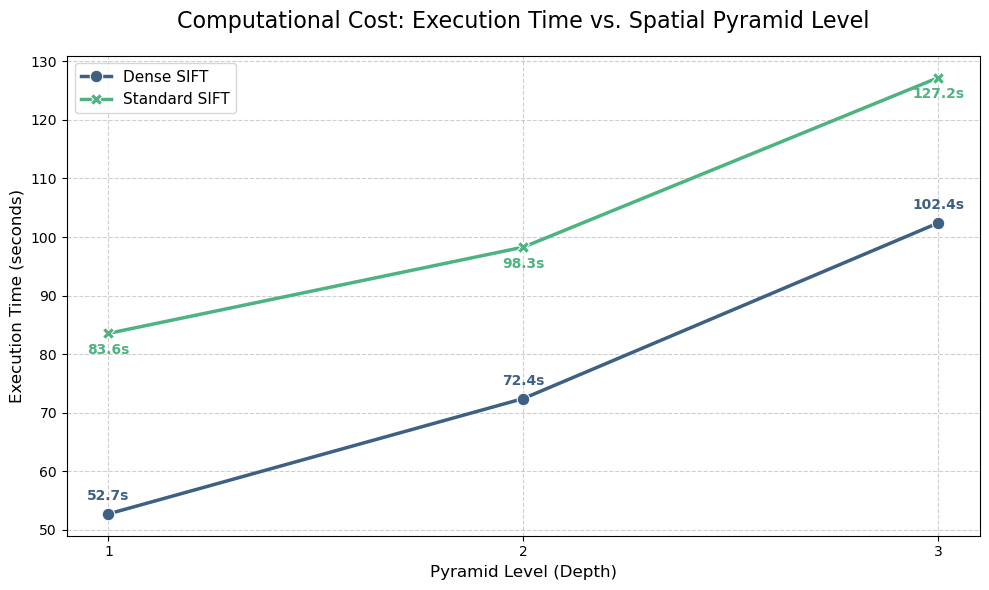

In [2]:
df = pd.read_csv("results/spatial_pyramid_200.csv")
plot_SP_times(df)

Contrary to our hypothesis, the application of Spatial Pyramids did not yield a robust improvement for our best configuration.
1. Overfitting: The results show a clear case of overfitting. While training accuracy increases, test accuracy stagnates or even decreases for the Dense SIFT configuration. This is likely due to the massive increase in dimensionality. For a 3-level pyramid (1x1, 2x2, 4x4), the final vector size increases by a factor of 21 ($1+4+16$). With our dataset size, this high-dimensional space leads the classifier to memorize training data rather than generalizing.
2. Marginal Gain for SIFT: Standard SIFT shows a slight improvement (approximately +3%) with pyramids. However, this gain is not proportional to the increase in model complexity and training divergence.
3. Computational Cost: As expected, the execution time and memory requirements grow linearly with the size of the concatenated histogram.

In conclusion, given the evidence of overfitting and the high computational cost, we will discard Spatial Pyramids for the final system. The high dimensionality introduced by SPM requires significantly more training data to be effective. We will proceed with the global (Level 0) Dense SIFT representation, which offers the best balance of accuracy and generalization for this specific dataset.

### 8 - Classifiers

#### Logistic Regression

With our feature extraction pipeline finalized (Dense SIFT, $k=200$, L2 + MinMax Scaling), we now turn our attention to the classification stage. We begin by establishing a linear baseline using Logistic Regression.

The primary hyperparameter for Logistic Regression is the regularization strength $C$ (inverse of regularization parameter $\lambda$). This controls the complexity of the model by penalizing large weights.

Hypothesis: The parameter $C$ governs the bias-variance trade-off. We hypothesize that a very low $C$ (high regularization) will cause underfitting by suppressing essential feature weights, while a very high $C$ (low regularization) will allow the model to memorize noise, leading to overfitting. We anticipate a 'sweet spot' in the middle values where generalization is maximized.

In [35]:
config_path = "configs/logistic_classifier.json"
results_path = "results/logistic_classifier_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/logistic_classifier_200.csv
Loaded 4 experiments from configs/logistic_classifier.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0  LogisticRegression (C=0.01)        0.338276       0.325000   
1   LogisticRegression (C=0.1)        0.396897       0.364091   
2   LogisticRegression (C=1.0)        0.430690       0.369091   
3  LogisticRegression (C=10.0)        0.442644       0.366364   

                                           CV Scores   Time (s)  
0  [0.30057471 0.30229885 0.27643678 0.28333333 0...  55.695253  
1  [0.31954023 0.33793103 0.31206897 0.30574713 0...  57.047663  
2  [0.33678161 0.33908046 0.31551724 0.32356322 0...  57.780122  
3  [0.34482759 0.32126437 0.30689655 0.32068966 0...  68.678987

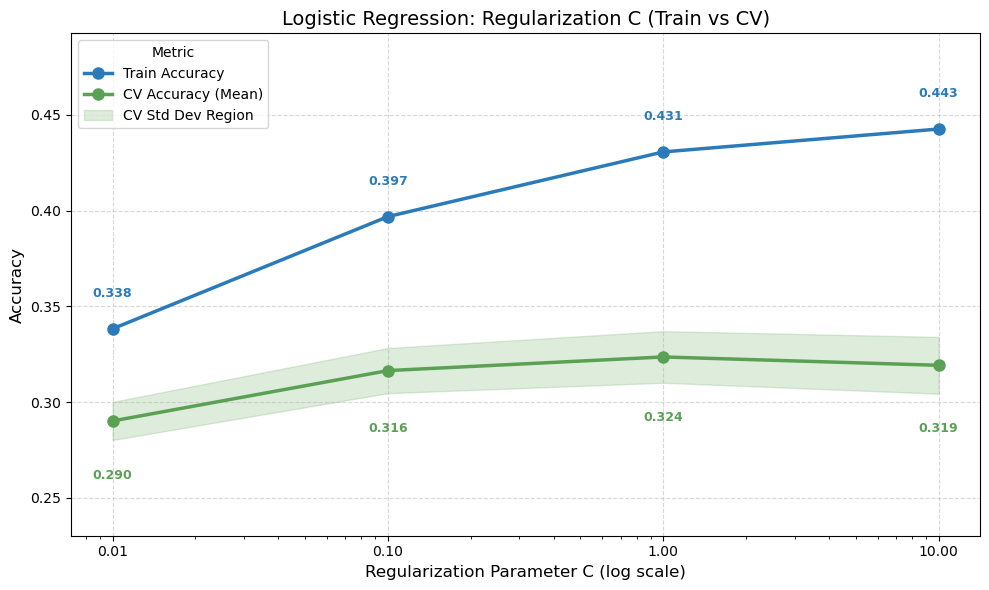

In [31]:
df = pd.read_csv("results/logistic_classifier_200.csv")
plot_logistic(df)

Question: Which is the impact on performance of each parameter? (Results & Analysis) The results of the regularization confirm the classic bias-variance curve:
- Underfitting ($C=0.01$): The model performs poorly on both Training (0.338) and Cross-Validation (0.290) sets. The strong regularization penalty forces the weights too close to zero, preventing the classifier from learning the decision boundaries effectively.
- Optimal Generalization ($C=1.0$): Hypothesis Validated. Performance peaks at $C=1.0$ with a CV accuracy of 0.324. At this point, the model captures sufficient complexity (Train 0.431) without succumbing to excessive variance.
- Overfitting ($C=10.0$): As we relax the regularization further, Training accuracy climbs to 0.443, but CV accuracy drops slightly to 0.319. The widening gap between the train and CV accuracies lines indicates the model is beginning to fit noise in the training data rather than general patterns.

Before making the decision of taking into account the Logistic Regression with the parameter $C=1.0$, we have to evaluate the Supor Vector Machines in order to see if they can improve the results we have obtained so far.

#### SVM

Having established a linear baseline with Logistic Regression ($C=1.0$, Accuracy: 0.324), we now explore Support Vector Machines (SVM). SVMs are particularly powerful for high-dimensional histograms like Bag of Visual Words.

We test three different kernel functions to map the data into higher-dimensional spaces:
1. Linear Kernel: Assumes classes are linearly separable.
2. RBF (Radial Basis Function) Kernel: A standard non-linear kernel based on Euclidean distance.
3. Histogram Intersection Kernel: A specialized kernel often cited in computer vision as optimal for comparing histogram-based features.

Hypothesis: We hypothesize that non-linear kernels (RBF and Histogram Intersection) will outperform the Linear kernel by capturing complex, non-linear relationships between visual words. Specifically, the Histogram Intersection kernel is expected to perform best as it mathematically aligns with the nature of histogram data, unlike the Euclidean-based RBF.

In [34]:
config_path = "configs/svm_classifier.json"
results_path = "results/svm_classifier_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/svm_classifier_200.csv
Loaded 12 experiments from configs/svm_classifier.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0                  SVM-Linear (C=0.01)        0.331954       0.318182   
1                   SVM-Linear (C=0.1)        0.404483       0.356818   
2                   SVM-Linear (C=1.0)        0.460460       0.366364   
3                  SVM-Linear (C=10.0)        0.497126       0.351818   
4                     SVM-RBF (C=0.01)        0.131954       0.143636   
5                      SVM-RBF (C=0.1)        0.387586       0.335455   
6                      SVM-RBF (C=1.0)        0.698506       0.391364   
7                     SVM-RBF (C=10.0)        0.998966       0.381364   
8   SVM-HistogramIntersection (C=0.01)        0.397816       0.340455   
9    SVM-HistogramIntersection (C=0.1)        0.594368       0.381818   
10   SVM-HistogramIntersection (C=1.0)        0.971149       0.326818   
11  SVM-HistogramIntersection (C=10.0)        1.000000       0.324545   

                                            CV Scores    Time (s)  
0   [0.29482759 0.29827586 0.2591954  0.27068966 0...  140.482209  
1   [0.32471264 0.34195402 0.31551724 0.30689655 0...  121.882066  
2   [0.32758621 0.33678161 0.30862069 0.31206897 0...  124.332542  
3   [0.31551724 0.31494253 0.29770115 0.30689655 0...  155.113540  
4   [0.0816092  0.08045977 0.08505747 0.08045977 0...  219.161236  
5   [0.30172414 0.31724138 0.28965517 0.28103448 0...  174.206588  
6   [0.3454023  0.35114943 0.32011494 0.32183908 0...  167.348077  
7   [0.32356322 0.33448276 0.31436782 0.32126437 0...  184.274508  
8   [0.32528736 0.34310345 0.29137931 0.29655172 0...  217.926286  
9   [0.35114943 0.34425287 0.31724138 0.32183908 0...  228.170747  
10  [0.30632184 0.28850575 0.2954023  0.29655172 0...  234.615279  
11  [0.30747126 0.28390805 0.29195402 0.29022989 0...  233.441985

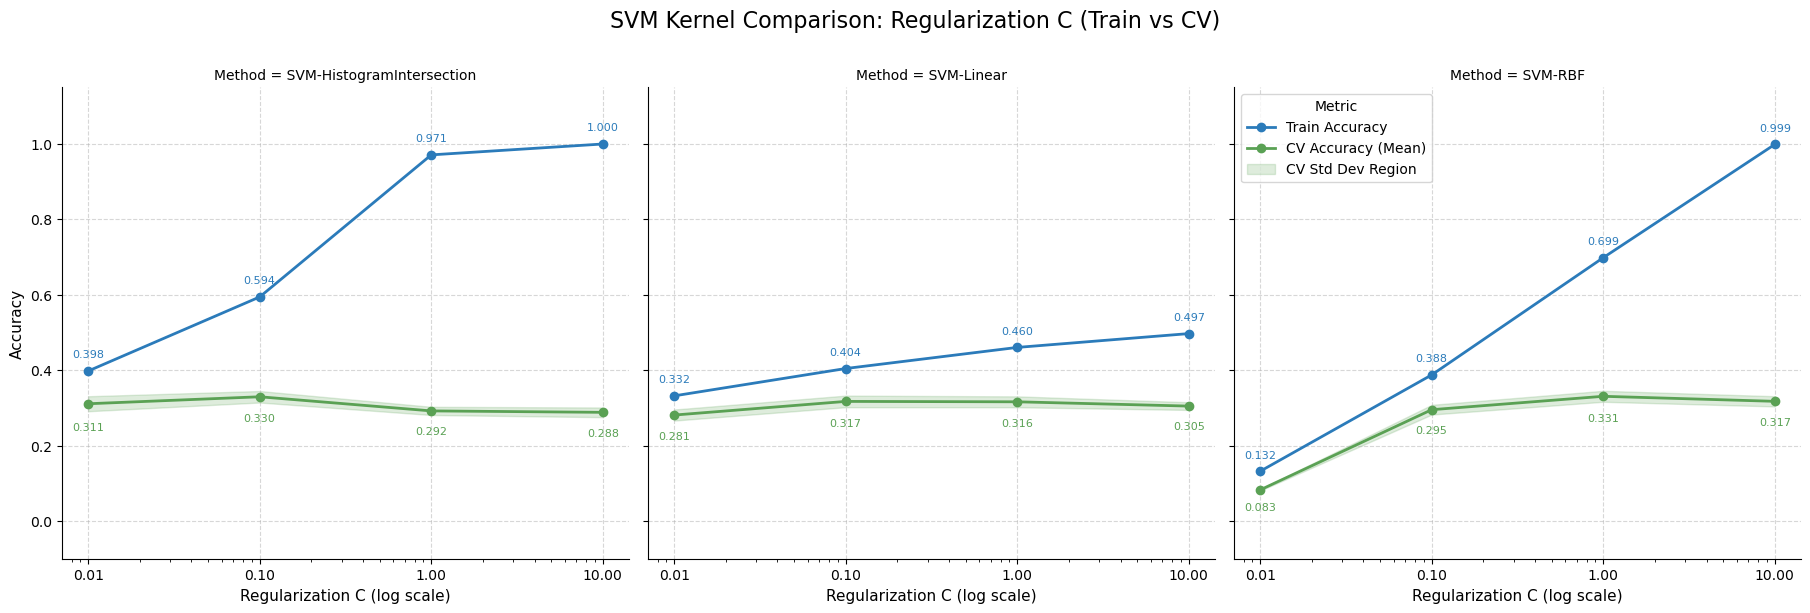

In [33]:
df = pd.read_csv("results/svm_classifier_200.csv")
plot_svm(df)

Question: Which is the impact on performance of each parameter? (Results & Analysis) The kernel comparison reveals distinct behaviors regarding overfitting and peak performance:
- SVM-Linear: Performance peaks at $C=0.1$ (0.317). This performs slightly worse than our Logistic Regression baseline (0.324). It confirms that a purely linear decision boundary is insufficient to capture the full complexity of the data, regardless of the regularization strength.
- SVM-RBF: Achieves the absolute highest numerical accuracy of 0.331 at $C=1.0$. While powerful, this configuration exhibits signs of significant overfitting. The gap between Training accuracy ($\approx$ 0.70) and CV accuracy (0.331) is large ($\approx$ 37%), indicating that the model is beginning to memorize the training set rather than generalizing robustly.
- SVM-Histogram Intersection: Reaches a competitive peak at $C=0.1$ with a CV accuracy of 0.330. This kernel matches the performance of the RBF kernel (difference is negligible, $<0.1\%$) but does so with a much smaller generalization gap (Training accuracy $\approx$ 0.59 vs RBF's 0.70). This indicates a more stable model that captures the underlying data structure without excessive memorization. However, we note that this kernel is very sensitive; increasing $C$ to 1.0 causes immediate and severe overfitting (Train 0.97 vs CV 0.29).

So, although the RBF kernel ($C=1.0$) yielded a marginally higher score, we prioritize model stability and generalization. The SVM with Histogram Intersection Kernel ($C=0.1$) provides practically identical performance (0.330) with significantly less overfitting than RBF. Therefore, we select this configuration of SVM to compare it with the Logistic Regression configuration we commented before.

#### SVM-RBF

In [3]:
config_path = "configs/svm_rbf_gamma.json"
results_path = "results/svm_rbf_gamma_200.csv"

df = run_experiments_from_config(config_path, results_path)
display(df)

Resuming from existing file: results/svm_rbf_gamma_200.csv
Loaded 5 experiments from configs/svm_rbf_gamma.json
0 experiments to run after filtering completed ones.
Processed Results:


Descriptor  Train Accuracy  Test Accuracy  \
0  SVM-RBF (Gamma=scale)        0.698506       0.391364   
1   SVM-RBF (Gamma=auto)        0.331494       0.317727   
2      SVM-RBF (Gamma=1)        0.958966       0.374545   
3     SVM-RBF (Gamma=10)        1.000000       0.095455   
4    SVM-RBF (Gamma=0.1)        0.400000       0.277273   

                                           CV Scores    Time (s)  
0  [0.3454023  0.35114943 0.32011494 0.32183908 0...  170.923954  
1  [0.29252874 0.29827586 0.2591954  0.27068966 0...  174.544940  
2  [0.33045977 0.3316092  0.30862069 0.3137931  0...  197.515906  
3  [0.10172414 0.09597701 0.09425287 0.0954023  0...  191.420638  
4  [0.21954023 0.24252874 0.24712644 0.22068966 0...  285.807644

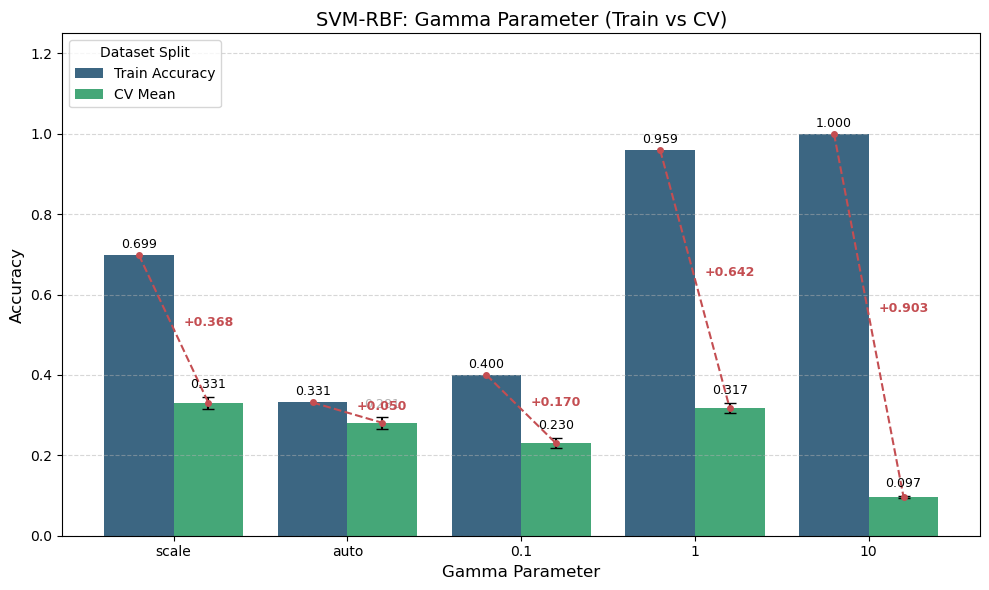

In [4]:
df = pd.read_csv("results/svm_rbf_gamma_200.csv")
plot_svm_rbf_gamma(df)

## Final Test

In [26]:
from final_evaluation import *
import matplotlib.image as mpimg

def plot_image(image_path):
    plt.figure(figsize=(15, 5))

    img = mpimg.imread(image_path)

    plt.imshow(img)
    plt.axis('off') 

    plt.tight_layout()
    plt.show()

In [ ]:
evaluate_model(config_path="configs/final_model_LR.json", output_dir="results/final_evaluation_LR")

Evaluating Final Model: LogisticRegression (C=1.0)
Configuration: {'data_path': '../data/MIT_split/', 'seed': 42, 'detector': 'SIFT', 'detector_kwargs': {}, 'dense': True, 'step_size': 8, 'scale': 8, 'codebook_size': 500, 'spatial_pyramid': True, 'levels': [1], 'use_pca': False, 'pca_components': 64, 'classifier': 'LogisticRegression', 'C': 1.0, 'gamma': 'scale', 'codebook_batch_size': 200, 'max_samples_train': None, 'max_samples_test': None}
Loading datasets...
Loaded 8700 images from ../data/MIT_split/train
Loaded 2200 images from ../data/MIT_split/test
Descriptors found on disk. Loading...
Found cached model at results/final_evaluation_LR\model.pkl. Loading...
Model loaded successfully.
Processing Test Set...
[test] Gathering file paths...
Computing BoVW histograms (Test)...


Computing BoVW Histograms: 100%|██████████| 2200/2200 [00:02<00:00, 743.10it/s]


Predicting...

FINAL EVALUATION RESULTS
ROC Curve saved.
Accuracy:  0.3964
Precision: 0.3922
Recall:    0.3964
F1 Score:  0.3884
ROC AUC:   0.8345
Confusion Matrix saved.
Analyzing misclassified examples...
Top 5 misclassified examples saved.

Evaluation Complete. Results saved to results/final_evaluation_LR


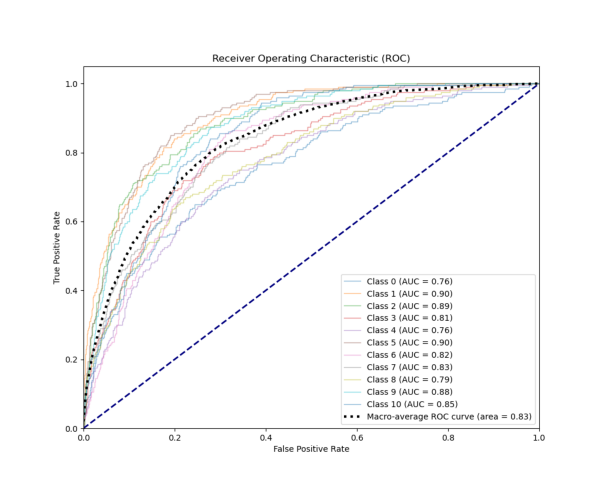

In [27]:
plot_image("results/final_evaluation_LR/roc_curve.png")

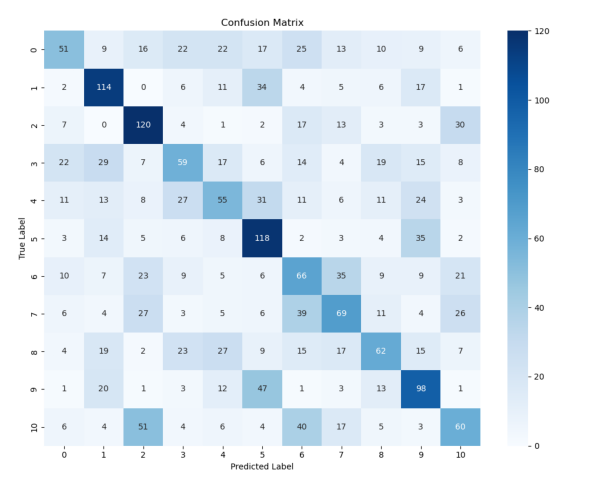

In [28]:
plot_image("results/final_evaluation_LR/confusion_matrix.png")

In [8]:
evaluate_model(config_path="configs/final_model_SVM.json", output_dir="results/final_evaluation_SVM")

Evaluating Final Model: SVM-HistogramIntersection (C=0.1)
Configuration: {'data_path': '../data/MIT_split/', 'seed': 42, 'detector': 'SIFT', 'detector_kwargs': {}, 'dense': True, 'step_size': 8, 'scale': 8, 'codebook_size': 200, 'spatial_pyramid': False, 'levels': [1], 'use_pca': False, 'pca_components': 64, 'normalization': 'l2', 'scaler': 'MinMaxScaler', 'classifier': 'SVM-HistogramIntersection', 'C': 0.1, 'gamma': 'scale', 'codebook_batch_size': 200, 'max_samples_train': None, 'max_samples_test': None}
Loading datasets...
Loaded 8700 images from ../data/MIT_split/train
Loaded 2200 images from ../data/MIT_split/test
Descriptors found on disk. Loading...
Found cached model at results/final_evaluation_SVM\model.pkl. Loading...
Model loaded successfully.
Processing Test Set...
[test] Gathering file paths...
Computing BoVW histograms (Test)...


Computing BoVW Histograms: 100%|██████████| 2200/2200 [00:02<00:00, 764.92it/s]


Applying Scaler transform...
Predicting...

FINAL EVALUATION RESULTS
ROC Curve saved.
Accuracy:  0.3818
Precision: 0.3769
Recall:    0.3818
F1 Score:  0.3753
ROC AUC:   0.8329
Confusion Matrix saved.
Analyzing misclassified examples...
Top 5 misclassified examples saved.

Evaluation Complete. Results saved to results/final_evaluation_SVM


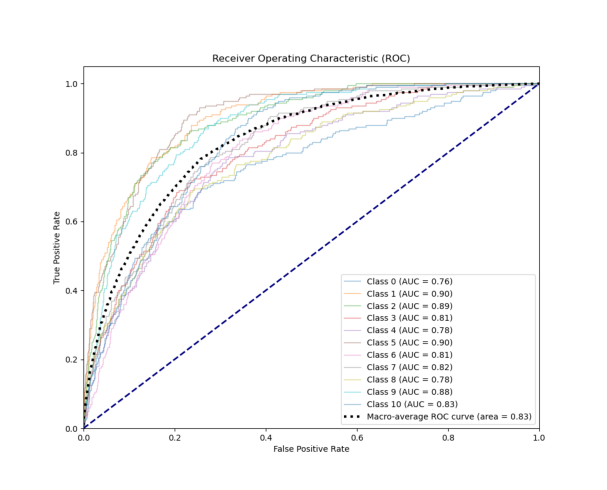

In [29]:
plot_image("results/final_evaluation_SVM/roc_curve.png")

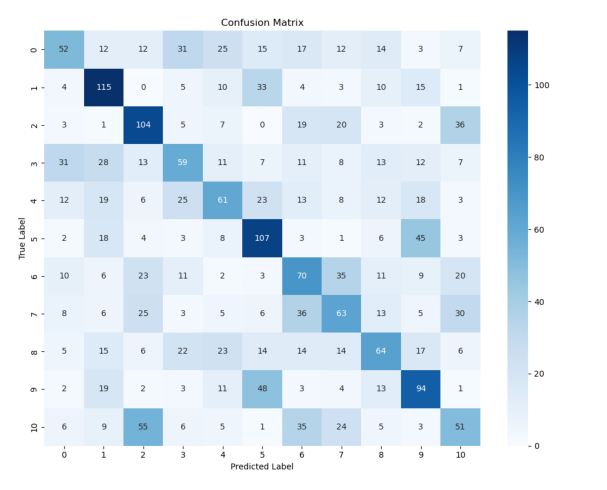

In [30]:
plot_image("results/final_evaluation_SVM/confusion_matrix.png")